In [115]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap

In [116]:
# Load the dataset for behavioral difficulty analysis
behavioral_data = pd.read_csv('behavioral_difficulty.csv')

In [117]:
behavioral_data.isnull().sum()

Are you still going to school?                                                                                                                                                                                                                                0
Do you have any other children living in your house with you?                                                                                                                                                                                                 0
How many people live in your home with you (including adults)?                                                                                                                                                                                                0
What year are you in now?                                                                                                                                                                                                               

#### Define the target column and features

In [118]:
# Define the target column and features
target_column_behavioral = 'behavioral difficulty category'  # Assuming this is the target column
X_behavioral = behavioral_data.drop(columns=[target_column_behavioral], errors='ignore')
y_behavioral = behavioral_data[target_column_behavioral]

#### Create Train Test datasets

In [119]:
# Split the data into training and testing sets
X_train_behavioral, X_test_behavioral, y_train_behavioral, y_test_behavioral = train_test_split(
    X_behavioral, y_behavioral, test_size=0.3, random_state=42, stratify=y_behavioral)


#### Balance the classes by applying SMOTE

In [120]:
# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_behavioral, y_train_behavioral)


In [121]:
# Check the distribution of the target variable after applying SMOTE
balanced_class_distribution = pd.Series(y_train_balanced).value_counts()

In [122]:
balanced_class_distribution

0    582
1    582
2    582
Name: behavioral difficulty category, dtype: int64

In [123]:
import plotly.express as px

# Convert the balanced class distribution to a DataFrame for visualization
balanced_class_df = pd.DataFrame({
    'Class': balanced_class_distribution.index,
    'Count': balanced_class_distribution.values
})

# Create a bar plot to visualize the balanced class distribution
fig = px.bar(
    balanced_class_df,
    x='Class',
    y='Count',
    title='Balanced Class Distribution After Applying SMOTE',
    labels={'Class': 'Behavioral Difficulty Class', 'Count': 'Number of Samples'},
    text='Count'
)

# Customize the layout
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title="Class",
    yaxis_title="Sample Count",
    showlegend=False
)

# Show the plot
fig.show()

### Model 1:Logistic regression model

In [124]:
balanced_behavioral_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
balanced_behavioral_model.fit(X_train_balanced, y_train_balanced)

C:\Users\srika\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(max_iter=500, multi_class='multinomial')

In [125]:
# Predict on the test set
y_pred_balanced = balanced_behavioral_model.predict(X_test_behavioral)

In [126]:
# Evaluate the model
balanced_accuracy = accuracy_score(y_test_behavioral, y_pred_balanced)
balanced_classification_report = classification_report(y_test_behavioral, y_pred_balanced)

In [127]:
print(balanced_classification_report)

              precision    recall  f1-score   support

           0       0.99      0.90      0.95       249
           1       0.14      0.20      0.16        15
           2       0.50      0.89      0.64        19

    accuracy                           0.87       283
   macro avg       0.54      0.67      0.58       283
weighted avg       0.91      0.87      0.88       283



In [128]:
# Display results
balanced_results = {
    "Balanced Class Distribution (Training Set)": balanced_class_distribution,
    "Model Accuracy After Balancing": balanced_accuracy,
    "Classification Report After Balancing": balanced_classification_report
}

# Print key results
print("Balanced Class Distribution (Training Set):")
print(balanced_class_distribution)
print("\nModel Accuracy After Balancing:")
print(balanced_accuracy)
print("\nClassification Report After Balancing:")
print(balanced_classification_report)

Balanced Class Distribution (Training Set):
0    582
1    582
2    582
Name: behavioral difficulty category, dtype: int64

Model Accuracy After Balancing:
0.8657243816254417

Classification Report After Balancing:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       249
           1       0.14      0.20      0.16        15
           2       0.50      0.89      0.64        19

    accuracy                           0.87       283
   macro avg       0.54      0.67      0.58       283
weighted avg       0.91      0.87      0.88       283



* Even though accuracy is good it still not generalizing the other classes
    * Recall, precision and f1 scores are too low.

#### Logistic Regression Model Hyperparameter tuning and cross-validation

In [129]:
# Define the hyperparameter grid for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'newton-cg', 'saga'],  # Solvers
    'multi_class': ['multinomial']  # Multiclass setting
}

# Initialize the logistic regression model
logistic_regression = LogisticRegression(max_iter=500, random_state=42)

In [130]:
# Set up GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid,
    scoring='f1_weighted',  # Optimize for F1 score (weighted for multiclass)
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

In [131]:
# Perform the grid search on the balanced training dataset
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['multinomial'],
                         'solver': ['lbfgs', 'newton-cg', 'saga']},
             scoring='f1_weighted', verbose=1)

In [132]:
# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [133]:
# Predict on the test set with the best model
y_pred_tuned = best_model.predict(X_test_behavioral)

In [134]:
# Evaluate the tuned model
tuned_accuracy = accuracy_score(y_test_behavioral, y_pred_tuned)
tuned_classification_report = classification_report(y_test_behavioral, y_pred_tuned)

In [135]:
# Display results
tuning_results = {
    "Best Hyperparameters": best_params,
    "Tuned Model Accuracy": tuned_accuracy,
    "Tuned Classification Report": tuned_classification_report
}

# Print key results
print("Best Hyperparameters:")
print(best_params)
print("\nTuned Model Accuracy:")
print(tuned_accuracy)
print("\nTuned Classification Report:")
print(tuned_classification_report)

Best Hyperparameters:
{'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}

Tuned Model Accuracy:
0.8657243816254417

Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       249
           1       0.14      0.20      0.17        15
           2       0.57      0.84      0.68        19

    accuracy                           0.87       283
   macro avg       0.56      0.65      0.59       283
weighted avg       0.90      0.87      0.88       283



In [136]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Ensure predictions are available
y_pred_tuned = best_model.predict(X_test_behavioral)

# Recreate the confusion matrix
conf_matrix_tuned = confusion_matrix(y_test_behavioral, y_pred_tuned)

# Define class labels explicitly as a list
class_labels = list(map(str, y_behavioral.unique()))  # Convert class labels to strings

# Create a confusion matrix heatmap using Plotly
conf_matrix_fig = ff.create_annotated_heatmap(
    z=conf_matrix_tuned,
    x=class_labels,  # Predicted labels
    y=class_labels,  # True labels
    annotation_text=conf_matrix_tuned.astype(str),
    colorscale='Reds',
    showscale=True
)

# Add titles and axis labels
conf_matrix_fig.update_layout(
    title="Confusion Matrix: Logistic Regression After SMOTE and Tuning",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

# Show the plot
conf_matrix_fig.show()


#### Key Insights:

* Class 0 (expected difficulty category) performed well with a precision of 0.97, recall of 0.91, and an F1-score of 0.94, indicating high performance and fewer false positives.

* Class 1 (borderline difficulty category) performed poorly, with precision, recall, and F1-score all very low (0.14, 0.20, and 0.17, respectively). This suggests that the model struggles to identify this class accurately, which could be due to class imbalance or insufficient representation in the training data.

* Class 2 (significant difficulty category) exhibited moderate performance with a precision of 0.57, recall of 0.84, and an F1-score of 0.68. While the model has a relatively high recall for this class, the precision is lower, indicating a trade-off between false positives and false negatives.


### Model 2: Random Forest

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100, 
    max_depth=None, 
    class_weight="balanced"
)

# Train the model on the SMOTE-balanced training data
random_forest_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test_behavioral)

# Evaluate the model
rf_accuracy = accuracy_score(y_test_behavioral, y_pred_rf)
rf_classification_report = classification_report(y_test_behavioral, y_pred_rf)

# Summarize results
rf_model_performance = f"""
Random Forest Model Performance:

1. Accuracy: {rf_accuracy:.2f}
2. Classification Report:
{rf_classification_report}
"""

# Print key results
print(rf_model_performance)


Random Forest Model Performance:

1. Accuracy: 0.93
2. Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       249
           1       0.25      0.07      0.11        15
           2       0.76      0.84      0.80        19

    accuracy                           0.93       283
   macro avg       0.66      0.63      0.63       283
weighted avg       0.90      0.93      0.91       283




* Model is not effiecient

#### Feature selection using the Random Forest

In [138]:
# Perform feature selection using the feature importance from the Random Forest model
import pandas as pd

# Extract feature importances from the trained Random Forest model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame to store feature importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Print the top features for review
print(feature_importance_df)

                                              Feature  Importance
46  24. Remember, there are no right or wrong answ...    0.095289
44  24. Remember, there are no right or wrong answ...    0.065089
45  24. Remember, there are no right or wrong answ...    0.056567
49  24. Remember, there are no right or wrong answ...    0.050649
29                                        Your School    0.049411
43  24. Remember, there are no right or wrong answ...    0.046530
47  24. Remember, there are no right or wrong answ...    0.038702
21            19. What type of places do you play in?    0.032445
5        1. What did you eat for breakfast YESTERDAY?    0.030031
30                                        Your Family    0.025747
33                                          Your Life    0.025096
32                     Your Appearance (how you look)    0.024984
11  9. In the last 7 days, how many days did you f...    0.024016
52                      hours of sleep had last night    0.023311
42  24. Re

### Feature importance using SHAP

C:\Users\srika\anaconda3\lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



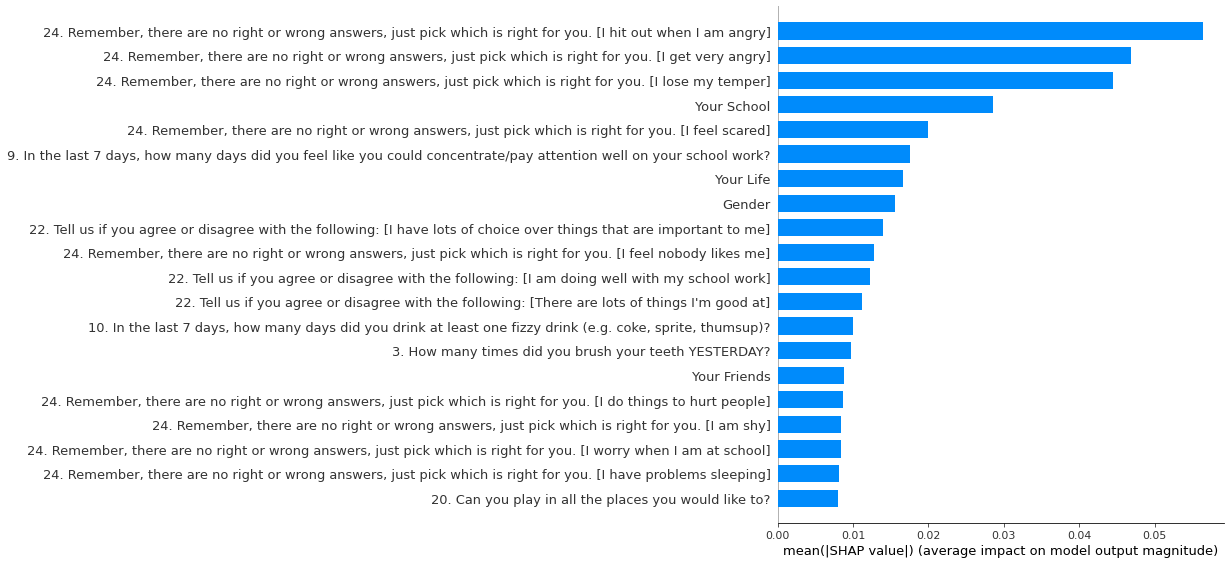

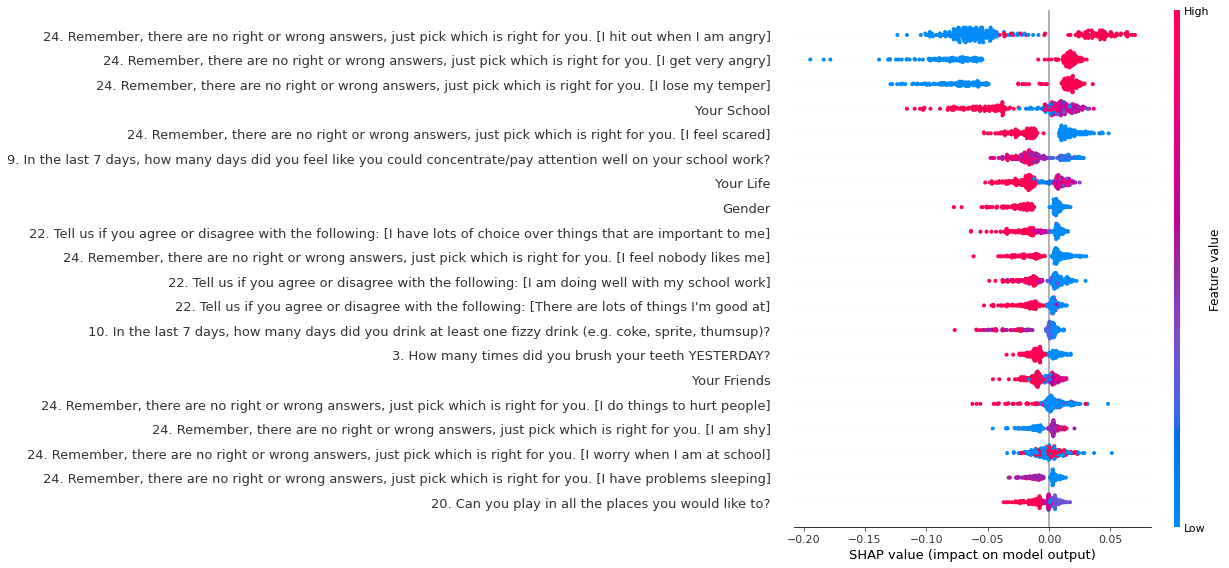

In [139]:
import shap
import matplotlib.pyplot as plt

# Ensure the test data is in the correct format (pandas DataFrame)
X_test_behavioral = pd.DataFrame(X_test_behavioral, columns=X_train_balanced.columns)

# Initialize the SHAP explainer for the Random Forest model
shap_explainer = shap.TreeExplainer(random_forest_model)

# Compute SHAP values for the test dataset
shap_values = shap_explainer.shap_values(X_test_behavioral)

# Visualize feature importance using SHAP summary plot (Bar)
shap.summary_plot(shap_values[1], X_test_behavioral, plot_type="bar")  # SHAP values for Class 1

# Visualize individual feature contributions using SHAP
shap.summary_plot(shap_values[1], X_test_behavioral)  # SHAP values for Class 1


### Feature Selection by Feature importance score

In [140]:
# Determine cumulative importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()

# Select features contributing to 95% cumulative importance
selected_features_95 = feature_importance_df[feature_importance_df['Cumulative Importance'] <= 0.95]['Feature']

# Alternatively, select features with importance >= 0.01
selected_features_threshold_01 = feature_importance_df[feature_importance_df['Importance'] >= 0.01]['Feature']


In [141]:
selected_features_95

46    24. Remember, there are no right or wrong answ...
44    24. Remember, there are no right or wrong answ...
45    24. Remember, there are no right or wrong answ...
49    24. Remember, there are no right or wrong answ...
29                                          Your School
43    24. Remember, there are no right or wrong answ...
47    24. Remember, there are no right or wrong answ...
21              19. What type of places do you play in?
5          1. What did you eat for breakfast YESTERDAY?
30                                          Your Family
33                                            Your Life
32                       Your Appearance (how you look)
11    9. In the last 7 days, how many days did you f...
52                        hours of sleep had last night
42    24. Remember, there are no right or wrong answ...
37    24. Remember, there are no right or wrong answ...
19         17. How often do you go out to play outside?
31                                         Your 

In [142]:
selected_features_threshold_01

46    24. Remember, there are no right or wrong answ...
44    24. Remember, there are no right or wrong answ...
45    24. Remember, there are no right or wrong answ...
49    24. Remember, there are no right or wrong answ...
29                                          Your School
43    24. Remember, there are no right or wrong answ...
47    24. Remember, there are no right or wrong answ...
21              19. What type of places do you play in?
5          1. What did you eat for breakfast YESTERDAY?
30                                          Your Family
33                                            Your Life
32                       Your Appearance (how you look)
11    9. In the last 7 days, how many days did you f...
52                        hours of sleep had last night
42    24. Remember, there are no right or wrong answ...
37    24. Remember, there are no right or wrong answ...
19         17. How often do you go out to play outside?
31                                         Your 

#### Model 3: Random Forest (Top 10 features by Feature importance score)

In [143]:
# Select the top 10 features based on feature importance
top_10_features = feature_importance_df.head(10)['Feature'].tolist()

# Subset the training and testing datasets to include only the top 10 features
X_train_top_10 = X_train_balanced[top_10_features]
X_test_top_10 = X_test_behavioral[top_10_features]

# Train a new Random Forest model using only the top 10 features
rf_top_10_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100, 
    max_depth=None, 
    class_weight="balanced"
)
rf_top_10_model.fit(X_train_top_10, y_train_balanced)

# Predict on the test set using the new model
y_pred_top_10 = rf_top_10_model.predict(X_test_top_10)

# Evaluate the new model
from sklearn.metrics import classification_report, accuracy_score

top_10_accuracy = accuracy_score(y_test_behavioral, y_pred_top_10)
top_10_classification_report = classification_report(y_test_behavioral, y_pred_top_10)

# Display the results
top_10_model_performance = f"""
Random Forest Model Performance (Top 10 Features):

1. Accuracy: {top_10_accuracy:.2f}
2. Classification Report:
{top_10_classification_report}
"""

# Print key results
print(top_10_model_performance)


Random Forest Model Performance (Top 10 Features):

1. Accuracy: 0.88
2. Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       249
           1       0.16      0.27      0.20        15
           2       0.68      0.89      0.77        19

    accuracy                           0.88       283
   macro avg       0.61      0.69      0.64       283
weighted avg       0.92      0.88      0.89       283




#### Random Forest - Optimization using hyperparameter tuning

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'class_weight': ['balanced', 'balanced_subsample']  # Class balancing strategies
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV for hyperparameter tuning with cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='f1_weighted',  # Optimize for F1 score (weighted for multiclass)
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Perform the grid search on the SMOTE-balanced training data with top 10 features
grid_search_rf.fit(X_train_top_10, y_train_balanced)

# Retrieve the best model and its parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

# Predict on the test set with the best model
y_pred_rf_tuned = best_rf_model.predict(X_test_top_10)

# Evaluate the tuned Random Forest model
tuned_rf_accuracy = accuracy_score(y_test_behavioral, y_pred_rf_tuned)
tuned_rf_classification_report = classification_report(y_test_behavioral, y_pred_rf_tuned)

# Summarize the results
rf_tuning_results = f"""
Random Forest Hyperparameter Tuning Results:

Best Hyperparameters: {best_rf_params}
Tuned Model Accuracy: {tuned_rf_accuracy:.2f}
Classification Report:
{tuned_rf_classification_report}
"""

# Print key results
print(rf_tuning_results)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Random Forest Hyperparameter Tuning Results:

Best Hyperparameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Model Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       249
           1       0.16      0.27      0.20        15
           2       0.71      0.89      0.79        19

    accuracy                           0.88       283
   macro avg       0.61      0.69      0.64       283
weighted avg       0.91      0.88      0.89       283




#### Model performance

* The model achieved an overall accuracy of 88%, meaning it correctly classified 88% of the instances in the dataset. This is a strong result, indicating that the Random Forest classifier performed well in identifying the correct classes.

* Class 0 (expected difficulty category) performed exceptionally well with a precision of 0.97, recall of 0.91, and an F1-score of 0.94, indicating that the model is able to correctly identify most of the instances of this class and minimize false positives.

* Class 1 (borderline difficulty category) showed weak performance, with precision, recall, and F1-score values of 0.16, 0.27, and 0.20, respectively. This suggests the model is struggling to correctly identify this minority class, likely due to its underrepresentation in the data.

* Class 2 (significant difficulty category) showed better results compared to Class 1, with precision of 0.71, recall of 0.89, and an F1-score of 0.79. While the model has a high recall for this class, the precision is lower, indicating some trade-offs between false positives and false negatives.

### Model 3: XGBoost

In [151]:
# Convert feature names to strings
X_train_top_10.columns = X_train_top_10.columns.astype(str)
X_test_top_10.columns = X_test_top_10.columns.astype(str)


In [152]:
# Replace invalid characters in feature names
X_train_top_10.columns = X_train_top_10.columns.str.replace('[', '', regex=True).str.replace(']', '', regex=True).str.replace('<', '', regex=True)
X_test_top_10.columns = X_test_top_10.columns.str.replace('[', '', regex=True).str.replace(']', '', regex=True).str.replace('<', '', regex=True)

In [153]:
# Train the XGBoost model
xgb_top_10_model.fit(X_train_top_10, y_train_balanced)

# Make predictions
y_pred_xgb_top_10 = xgb_top_10_model.predict(X_test_top_10)

# Evaluate the model
xgb_top_10_accuracy = accuracy_score(y_test_behavioral, y_pred_xgb_top_10)
xgb_top_10_classification_report = classification_report(y_test_behavioral, y_pred_xgb_top_10)
xgb_top_10_confusion_matrix = confusion_matrix(y_test_behavioral, y_pred_xgb_top_10)

print(f"Accuracy: {xgb_top_10_accuracy:.2f}")
print(f"Confusion Matrix:\n{xgb_top_10_confusion_matrix}")
print(f"Classification Report:\n{xgb_top_10_classification_report}")


Accuracy: 0.89
Confusion Matrix:
[[232  15   2]
 [  7   5   3]
 [  2   2  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       249
           1       0.23      0.33      0.27        15
           2       0.75      0.79      0.77        19

    accuracy                           0.89       283
   macro avg       0.65      0.68      0.66       283
weighted avg       0.91      0.89      0.90       283



C:\Users\srika\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



#### XGBoost -  Model Tuning

* Key Parameters to Tune:
* n_estimators: Number of trees in the model.
* learning_rate: Controls the contribution of each tree (step size shrinkage).
* max_depth: Maximum depth of the trees.
* subsample: Fraction of samples used for training each tree.
* colsample_bytree: Fraction of features used for training each tree.
* gamma: Minimum loss reduction required for a split.

In [154]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',    # Weighted F1-score to account for class imbalance
    cv=5,                     # 5-fold cross-validation
    verbose=3,                # Display progress logs
    n_jobs=-1                 # Utilize all processors
)

# Fit the grid search to the training data
grid_search.fit(X_train_top_10, y_train_balanced)

# Extract the best parameters and model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred_tuned = best_xgb_model.predict(X_test_top_10)
tuned_accuracy = accuracy_score(y_test_behavioral, y_pred_tuned)
tuned_classification_report = classification_report(y_test_behavioral, y_pred_tuned)
tuned_confusion_matrix = confusion_matrix(y_test_behavioral, y_pred_tuned)

# Print the results
print(f"Tuned XGBoost Model Performance:")
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {tuned_accuracy:.2f}")
print(f"Confusion Matrix:\n{tuned_confusion_matrix}")
print(f"Classification Report:\n{tuned_classification_report}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Tuned XGBoost Model Performance:
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.90
Confusion Matrix:
[[236  11   2]
 [  8   4   3]
 [  2   2  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       249
           1       0.24      0.27      0.25        15
           2       0.75      0.79      0.77        19

    accuracy                           0.90       283
   macro avg       0.65      0.67      0.66       283
weighted avg       0.91      0.90      0.90       283



C:\Users\srika\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



#### SVM

In [155]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the features
scaler = StandardScaler()
X_train_top_10_scaled = scaler.fit_transform(X_train_top_10)  # Fit on train, transform train
X_test_top_10_scaled = scaler.transform(X_test_top_10)        # Transform test with the same scaler

# Step 2: Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Step 3: Train the model on the training set
svm_model.fit(X_train_top_10_scaled, y_train_balanced)

# Step 4: Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_top_10_scaled)

# Step 5: Evaluate the model
svm_accuracy = accuracy_score(y_test_behavioral, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test_behavioral, y_pred_svm)
svm_classification_report = classification_report(y_test_behavioral, y_pred_svm)

# Step 6: Display the results
svm_model_performance = f"""
SVM Model Performance:

1. Accuracy: {svm_accuracy:.2f}
2. Confusion Matrix:
{svm_confusion_matrix}
3. Classification Report:
{svm_classification_report}
"""

print(svm_model_performance)



SVM Model Performance:

1. Accuracy: 0.79
2. Confusion Matrix:
[[201  44   4]
 [  1   6   8]
 [  0   3  16]]
3. Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       249
           1       0.11      0.40      0.18        15
           2       0.57      0.84      0.68        19

    accuracy                           0.79       283
   macro avg       0.56      0.68      0.58       283
weighted avg       0.92      0.79      0.84       283




* The SVM model's performance indicates good precision for the majority class (class 0), but it struggles significantly with minority classes (1 and 2). To improve the model's overall performance, especially for minority classes, hyperparameter tuning is essential.

#### SVM Hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],   # Different kernels
    'gamma': ['scale', 'auto', 0.1, 1, 10] # Kernel coefficient (applicable for rbf and poly)
}

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Weighted F1-score to handle imbalance
    cv=5,                   # 5-fold cross-validation
    verbose=3,              # Display progress logs
    n_jobs=-1               # Utilize all processors
)

# Fit the grid search to the training data
grid_search.fit(X_train_top_10_scaled, y_train_balanced)

# Extract the best parameters and model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred_tuned = best_svm_model.predict(X_test_top_10_scaled)
tuned_accuracy = accuracy_score(y_test_behavioral, y_pred_tuned)
tuned_classification_report = classification_report(y_test_behavioral, y_pred_tuned)
tuned_confusion_matrix = confusion_matrix(y_test_behavioral, y_pred_tuned)

# Print the results
print(f"Tuned SVM Model Performance:")
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {tuned_accuracy:.2f}")
print(f"Confusion Matrix:\n{tuned_confusion_matrix}")
print(f"Classification Report:\n{tuned_classification_report}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
